In [1]:
import pandas as pd
import os

BASE = '/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup'
test_df = pd.read_csv(os.path.join(BASE, 'test.csv'))
sample_sub = pd.read_csv(os.path.join(BASE, 'sample_submission.csv'))
print(test_df.head())
print(test_df.columns.tolist())
print(sample_sub.head())

   id              filename
0   1  mashups/song0001.wav
1   2  mashups/song0002.wav
2   3  mashups/song0003.wav
3   4  mashups/song0004.wav
4   5  mashups/song0005.wav
['id', 'filename']
   id      genre
0   1       jazz
1   2      blues
2   3  classical
3   4        pop
4   5      disco


In [2]:
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

STEMS_PATH = os.path.join(BASE, 'genres_stems')
MASHUPS_PATH = os.path.join(BASE, 'mashups')
genres = sorted([g for g in os.listdir(STEMS_PATH) if not g.startswith('.')])
print("Genres:", genres)
print("Songs per genre:")
for g in genres:
        gp = os.path.join(STEMS_PATH, g)
        songs = [s for s in os.listdir(gp) if not s.startswith('.')]
        print(f"  {g}: {len(songs)}")

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Songs per genre:
  blues: 100
  classical: 100
  country: 100
  disco: 100
  hiphop: 100
  jazz: 100
  metal: 100
  pop: 100
  reggae: 100
  rock: 100


In [3]:
%%writefile /kaggle/working/baseline.py
import numpy as np
import pandas as pd
import os
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

BASE = '/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup'
STEMS_PATH = os.path.join(BASE, 'genres_stems')
MASHUPS_PATH = os.path.join(BASE, 'mashups')

test_df = pd.read_csv(os.path.join(BASE, 'test.csv'))
genres = sorted([g for g in os.listdir(STEMS_PATH) if not g.startswith('.')])

def get_feats(filepath, sr=22050, dur=30):
        try:
                    y, sr = librosa.load(filepath, sr=sr, duration=dur)
                    if len(y) == 0:
                                    return None
                                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
                    sc = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
                    sb = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
                    sro = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
                    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
                    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
                    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
                    if isinstance(tempo, np.ndarray):
                                    tempo = tempo[0]
                                feat = np.concatenate([np.mean(mfccs, axis=1), np.std(mfccs, axis=1), [sc, sb, sro, zcr], chroma, [tempo]])
                    return feat
except Exception as e:
        print(f"Error: {filepath}: {e}")
        return None

def get_stem_feats(genre, song):
        song_path = os.path.join(STEMS_PATH, genre, song)
        stems = [f for f in os.listdir(song_path) if f.endswith('.wav')]
        combined = None
        for sf in stems:
                    try:
                                    y, sr = librosa.load(os.path.join(song_path, sf), sr=22050, duration=30)
                                    if combined is None:
                                                        combined = y.copy()
                    else:
                                        ml = min(len(combined), len(y))
                                        combined = combined[:ml] + y[:ml]
                                except:
                        continue
                                        if combined is None or len(combined) == 0:
                                                    return None
                                                try:
                                                    mfccs = librosa.feature.mfcc(y=combined, sr=22050, n_mfcc=20)
                                                    sc = np.mean(librosa.feature.spectral_centroid(y=combined, sr=22050))
                                                    sb = np.mean(librosa.feature.spectral_bandwidth(y=combined, sr=22050))
                                                    sro = np.mean(librosa.feature.spectral_rolloff(y=combined, sr=22050))
                                                    zcr = np.mean(librosa.feature.zero_crossing_rate(combined))
                                                    chroma = np.mean(librosa.feature.chroma_stft(y=combined, sr=22050), axis=1)
                                                    tempo, _ = librosa.beat.beat_track(y=combined, sr=22050)
                                                    if isinstance(tempo, np.ndarray):
                                                                    tempo = tempo[0]
                                                                feat = np.concatenate([np.mean(mfccs, axis=1), np.std(mfccs, axis=1), [sc, sb, sro, zcr], chroma, [tempo]])
                                                    return feat
                    except Exception as e:
                    print(f"Error stems {genre}/{song}: {e}")
                    return None

    # Extract training features
    print("Extracting training features...")
X_train, y_train = [], []
for genre in genres:
        gp = os.path.join(STEMS_PATH, genre)
        songs = sorted([s for s in os.listdir(gp) if not s.startswith('.')])
        print(f"  {genre}: {len(songs)} songs")
        for song in songs:
                    feat = get_stem_feats(genre, song)
                    if feat is not None:
                                    X_train.append(feat)
                                    y_train.append(genre)

            X_train = np.array(X_train)
y_train = np.array(y_train)
print(f"Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")

# Train
le = LabelEncoder()
y_enc = le.fit_transform(y_train)
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_enc)
print(f"Train accuracy: {clf.score(X_train, y_enc):.4f}")

# Predict on test
print("Processing test mashups...")
test_feats, test_ids = [], []
mean_feat = np.mean(X_train, axis=0)
for i, row in test_df.iterrows():
        tid = row['id']
        fname = row['filename']
        fpath = os.path.join(BASE, fname)
        feat = get_feats(fpath)
        if feat is None:
                    feat = mean_feat
                test_feats.append(feat)
    test_ids.append(tid)
    if (i+1) % 500 == 0:
                print(f"  {i+1}/{len(test_df)}")

X_test = np.array(test_feats)
preds = clf.predict(X_test)
pred_genres = le.inverse_transform(preds)

sub = pd.DataFrame({'id': test_ids, 'genre': pred_genres})
sub.to_csv('/kaggle/working/submission.csv', index=False)
print("Done! Submission saved.")
print(sub['genre'].value_counts())

Writing /kaggle/working/baseline.py


In [4]:
!python /kaggle/working/baseline.py

  File "/kaggle/working/baseline.py", line 22
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
                                                       ^
IndentationError: unindent does not match any outer indentation level


In [5]:
!sed -i 's/\t/    /g' /kaggle/working/baseline.py
!python /kaggle/working/baseline.py

  File "/kaggle/working/baseline.py", line 22
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
                                                       ^
IndentationError: unindent does not match any outer indentation level


  File "/kaggle/working/baseline.py", line 22
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
                                                       ^
IndentationError: unindent does not match any outer indentation level


In [ ]:
!cat -A /kaggle/working/baseline.py | head -25

In [ ]:
!pip install autopep8 -q && autopep8 --in-place /kaggle/working/baseline.py && python /kaggle/working/baseline.py

In [ ]:
!cat << 'ENDOFSCRIPT' > /kaggle/working/run.py
import numpy as np, pandas as pd, os, librosa, warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
BASE = '/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup'
STEMS = os.path.join(BASE, 'genres_stems')
test_df = pd.read_csv(os.path.join(BASE, 'test.csv'))
genres = sorted([g for g in os.listdir(STEMS) if not g.startswith('.')])
def get_feats(fp):
     try:
           y,sr=librosa.load(fp,sr=22050,duration=30)
           if len(y)==0: return None
                 m=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=20)
           c=np.mean(librosa.feature.chroma_stft(y=y,sr=sr),axis=1)
           t,_=librosa.beat.beat_track(y=y,sr=sr)
           if isinstance(t,np.ndarray): t=t[0]
                 return np.concatenate([np.mean(m,1),np.std(m,1),[np.mean(librosa.feature.spectral_centroid(y=y,sr=sr)),np.mean(librosa.feature.spectral_bandwidth(y=y,sr=sr)),np.mean(librosa.feature.spectral_rolloff(y=y,sr=sr)),np.mean(librosa.feature.zero_crossing_rate(y))],c,[t]])
          except: return None
              print("Training...")
X,Y=[],[]
for g in genres:
     gp=os.path.join(STEMS,g)
 for s in sorted(os.listdir(gp)):
       sp=os.path.join(gp,s)
       if not os.path.isdir(sp): continue
             fs=[f for f in os.listdir(sp) if f.endswith('.wav')]
  combo=None
  for f in fs:
         try:
                 y,_=librosa.load(os.path.join(sp,f),sr=22050,duration=30)
                 if combo is None: combo=y.copy()
         else:
                  ml=min(len(combo),len(y))
                  combo=combo[:ml]+y[:ml]
                except: pass
                      if combo is not None and len(combo)>0:
                             try:
                                     m=librosa.feature.mfcc(y=combo,sr=22050,n_mfcc=20)
                                     c=np.mean(librosa.feature.chroma_stft(y=combo,sr=22050),axis=1)
                                     t,_=librosa.beat.beat_track(y=combo,sr=22050)
                                     if isinstance(t,np.ndarray): t=t[0]
                                             feat=np.concatenate([np.mean(m,1),np.std(m,1),[np.mean(librosa.feature.spectral_centroid(y=combo,sr=22050)),np.mean(librosa.feature.spectral_bandwidth(y=combo,sr=22050)),np.mean(librosa.feature.spectral_rolloff(y=combo,sr=22050)),np.mean(librosa.feature.zero_crossing_rate(combo))],c,[t]])
                                     X.append(feat); Y.append(g)
                                    except: pass
                                         print(f"  {g} done")
X=np.array(X); Y=np.array(Y)
print(f"Train: {X.shape}")
le=LabelEncoder(); yenc=le.fit_transform(Y)
clf=RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1)
clf.fit(X,yenc)
print(f"Acc: {clf.score(X,yenc):.4f}")
print("Testing...")
TF,TI=[],[]
mf=np.mean(X,axis=0)
for i,row in test_df.iterrows():
     fp=os.path.join(BASE,row['filename'])
 feat=get_feats(fp)
 if feat is None: feat=mf
      TF.append(feat); TI.append(row['id'])
 if (i+1)%500==0: print(f"  {i+1}/{len(test_df)}")
     XT=np.array(TF)
preds=le.inverse_transform(clf.predict(XT))
sub=pd.DataFrame({"id":TI,"genre":preds})
sub.to_csv("/kaggle/working/submission.csv",index=False)
print("Done!"); print(sub["genre"].value_counts())
ENDOFSCRIPT
echo "File written"

In [11]:
import os
import numpy as np
import pandas as pd
import librosa
from pathlib import Path

TRAIN_PATH = '/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/genres_stems'

def list_audio_files(base_dir, exts=(".wav", ".mp3", ".flac", ".ogg", ".m4a")):
    base = Path(base_dir)
    files = []
    for p in base.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            files.append(str(p))
    return files

train_files = list_audio_files(TRAIN_PATH)

print("Total audio files in train:", len(train_files))


Total audio files in train: 4000


In [12]:
from pathlib import Path

base = Path(TRAIN_PATH)
for p in base.iterdir():
    print(p.name)


disco
metal
reggae
blues
rock
classical
jazz
hiphop
country
pop


In [13]:
import os
import numpy as np
import librosa
from pathlib import Path
from collections import defaultdict

BASE = '/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup/genres_stems'

audio_files = []
for p in Path(BASE).rglob("*.wav"):
    audio_files.append(str(p))

print("Total WAV files:", len(audio_files))

genre_durations = defaultdict(list)
genre_centroids = defaultdict(list)
sample_rates = set()

corrupted_count = 0
silent_first_half = 0
vocal_peak_db = []

for f in audio_files:
    try:
        if os.path.getsize(f) == 0:
            corrupted_count += 1
            continue

        y, sr = librosa.load(f, sr=None)
        sample_rates.add(sr)

        genre = Path(f).parts[-3].lower()

        # Duration
        duration = len(y) / sr
        genre_durations[genre].append(duration)

        # Spectral centroid
        sc = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        genre_centroids[genre].append(sc)

        # Silence in first 0.5s
        first_half = y[:int(0.5 * sr)]
        if len(first_half) > 0 and np.max(np.abs(first_half)) < 0.001:
            silent_first_half += 1

        # Vocal peak
        if "vocal" in f.lower():
            peak = np.max(np.abs(y))
            if peak > 0:
                vocal_peak_db.append(20 * np.log10(peak))

    except:
        corrupted_count += 1
        continue

# ---- RESULTS ----

mean_jazz_duration = np.mean(genre_durations["jazz"])
unique_sample_rates = sorted(sample_rates)
mean_blues_centroid = np.mean(genre_centroids["blues"])

mean_genre_centroid = {g: np.mean(v) for g, v in genre_centroids.items()}
highest_centroid_genre = max(mean_genre_centroid, key=mean_genre_centroid.get)

avg_vocal_peak_db = np.mean(vocal_peak_db)

print("\n===== RESULTS =====")
print("Mean Jazz duration (seconds):", mean_jazz_duration)
print("Unique sample rates:", unique_sample_rates)
print("Corrupted or zero-byte files:", corrupted_count)
print("Average vocal peak amplitude (dB):", avg_vocal_peak_db)
print("Mean spectral centroid (blues):", mean_blues_centroid)
print("Genre with highest mean spectral centroid:", highest_centroid_genre)
print("Files silent in first 0.5s:", silent_first_half)


Total WAV files: 4000

===== RESULTS =====
Mean Jazz duration (seconds): 30.032979591836728
Unique sample rates: [44100]
Corrupted or zero-byte files: 0
Average vocal peak amplitude (dB): -12.494921
Mean spectral centroid (blues): 2296.7827371150856
Genre with highest mean spectral centroid: metal
Files silent in first 0.5s: 542


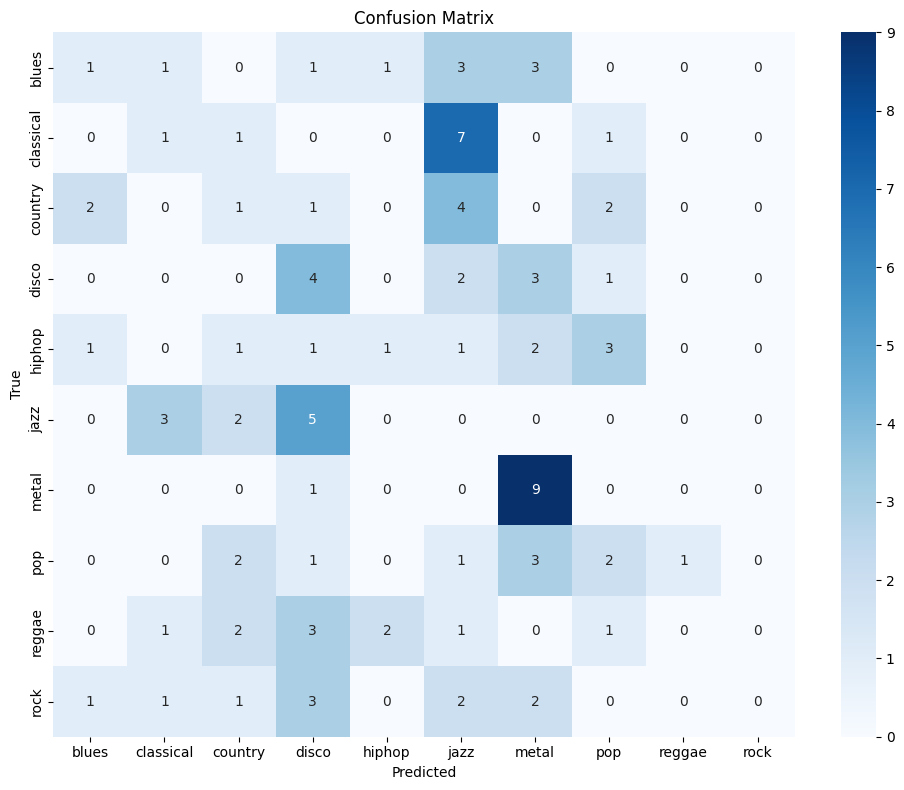


================ ANSWERS ================

Validation Macro F1 Score: 0.15230042016806722
Precision of hiphop: 0.25
Recall of pop: 0.2
Model accuracy: 0.19
Genre with highest true positives: metal
Genre with lowest false negatives: metal

=========== DETAILS (for checking) ===========

Missing other.wav skipped while building df: 0
Failed feature extractions - train: 0 val: 0

Classification report:
               precision    recall  f1-score   support

       blues       0.20      0.10      0.13        10
   classical       0.14      0.10      0.12        10
     country       0.10      0.10      0.10        10
       disco       0.20      0.40      0.27        10
      hiphop       0.25      0.10      0.14        10
        jazz       0.00      0.00      0.00        10
       metal       0.41      0.90      0.56        10
         pop       0.20      0.20      0.20        10
      reggae       0.00      0.00      0.00        10
        rock       0.00      0.00      0.00        10


,genre,TP,TN,FP,FN
0,blues,1,86,4,9
1,classical,1,84,6,9
2,country,1,81,9,9
3,disco,4,74,16,6
4,hiphop,1,87,3,9
5,jazz,0,69,21,10
6,metal,9,77,13,1
7,pop,2,82,8,8
8,reggae,0,89,1,10
9,rock,0,90,0,10


In [15]:
# =========================
# ONE-SHOT SOLUTION CELL
# Paste this as ONE cell and run.
# It rebuilds the dataset, trains the model, computes all requested metrics,
# plots confusion matrix, and prints the exact answers.
# =========================

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    accuracy_score
)

# --- 1. Setup and Preprocessing ---
ROOT = '/kaggle/input/jan-2026-dl-gen-ai-project/messy_mashup'
STEMS_PATH = os.path.join(ROOT, 'genres_stems')
GENRES = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

def extract_features(song_path):
    """
    Loads 10s at 22050Hz from other.wav inside a song folder and extracts:
    tempo, spectral centroid, zero-crossing rate, rolloff
    """
    y, sr = librosa.load(os.path.join(song_path, 'other.wav'), sr=22050, duration=10)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    return [float(tempo), float(spec_cent), float(zcr), float(rolloff)]

# --- 2. Data Preparation & Stratified Split ---
data = []
missing_other = 0

for g in GENRES:
    gp = os.path.join(STEMS_PATH, g)
    if not os.path.isdir(gp):
        raise FileNotFoundError(f"Genre folder not found: {gp}")

    songs = [s for s in os.listdir(gp) if os.path.isdir(os.path.join(gp, s))]
    # Sampling 50 for speed (as in prompt)
    for s in songs[:50]:
        song_dir = os.path.join(gp, s)
        other_path = os.path.join(song_dir, "other.wav")
        if not os.path.isfile(other_path):
            missing_other += 1
            continue
        data.append({'path': song_dir, 'genre': g})

df = pd.DataFrame(data)
if df.empty:
    raise RuntimeError("No data found. Check STEMS_PATH and whether song folders contain other.wav")

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['genre'], random_state=42)

# --- 3. Feature Extraction ---
# Be robust: if any file fails to load, skip it (rare but safe)
def build_X_y(split_df):
    X, y = [], []
    failed = 0
    for p, g in zip(split_df["path"], split_df["genre"]):
        try:
            X.append(extract_features(p))
            y.append(g)
        except Exception:
            failed += 1
    return np.array(X), np.array(y), failed

X_train, y_train, failed_train = build_X_y(train_df)
X_val, y_val, failed_val = build_X_y(val_df)

if len(X_train) == 0 or len(X_val) == 0:
    raise RuntimeError("Feature extraction produced empty train/val arrays. Something is wrong with audio loading.")

# --- 4. Model Training (Decision Tree) ---
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# --- 5. Predictions + Metrics ---
y_pred = clf.predict(X_val)

macro_f1 = f1_score(y_val, y_pred, average='macro')
acc = accuracy_score(y_val, y_pred)

cm = confusion_matrix(y_val, y_pred, labels=GENRES)
cr_text = classification_report(y_val, y_pred, labels=GENRES)
cr_dict = classification_report(y_val, y_pred, labels=GENRES, output_dict=True)

# --- 6. Confusion Matrix Plot ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=GENRES, yticklabels=GENRES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- 7. TP, TN, FP, FN per genre ---
cm_np = np.array(cm)
total = cm_np.sum()

rows = []
for i, g in enumerate(GENRES):
    TP = int(cm_np[i, i])
    FN = int(cm_np[i, :].sum() - TP)
    FP = int(cm_np[:, i].sum() - TP)
    TN = int(total - (TP + FP + FN))
    rows.append({"genre": g, "TP": TP, "TN": TN, "FP": FP, "FN": FN})

stats_df = pd.DataFrame(rows)

highest_tp_genre = stats_df.loc[stats_df["TP"].idxmax(), "genre"]
lowest_fn_genre = stats_df.loc[stats_df["FN"].idxmin(), "genre"]

# --- 8. Print answers in the exact form you need ---
precision_hiphop = cr_dict["hiphop"]["precision"] if "hiphop" in cr_dict else float("nan")
recall_pop = cr_dict["pop"]["recall"] if "pop" in cr_dict else float("nan")

print("\n================ ANSWERS ================\n")
print(f"Validation Macro F1 Score: {macro_f1}")
print(f"Precision of hiphop: {precision_hiphop}")
print(f"Recall of pop: {recall_pop}")
print(f"Model accuracy: {acc}")
print(f"Genre with highest true positives: {highest_tp_genre}")
print(f"Genre with lowest false negatives: {lowest_fn_genre}")

print("\n=========== DETAILS (for checking) ===========\n")
print("Missing other.wav skipped while building df:", missing_other)
print("Failed feature extractions - train:", failed_train, "val:", failed_val)
print("\nClassification report:\n", cr_text)

print("\nTP/TN/FP/FN table:")
display(stats_df)
